# Variational Quantum Eigensolver (VQE)

The tutorials requires `qiskit-nature` package which can be installed with [these](https://qiskit.org/ecosystem/nature/getting_started.html) instructions.

In [1]:
from qiskit.utils import algorithm_globals
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np

algorithm_globals.random_seed = 42

In [2]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import HartreeFock
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature import settings

from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import L_BFGS_B
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE

from qiskit_qulacs.qulacs_estimator import QulacsEstimator
from qiskit_qulacs.qulacs_estimator_gradient import QulacsEstimatorGradient

settings.use_pauli_sum_op = False

In [3]:
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

In [4]:
problem = driver.run()
fermionic_op = problem.hamiltonian.second_q_op()

mapper = JordanWignerMapper()
qubit_op = mapper.map(fermionic_op)
print(qubit_op)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'ZIIZ', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.81054798+0.j,  0.17218393+0.j, -0.22575349+0.j,  0.17218393+0.j,
 -0.22575349+0.j,  0.12091263+0.j,  0.16892754+0.j,  0.0452328 +0.j,
  0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,  0.16614543+0.j,
  0.16614543+0.j,  0.17464343+0.j,  0.12091263+0.j])


/home/gopald/Documents/qiskit-qulacs/qislacs/lib/python3.8/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [5]:
print("Number of qubits:", qubit_op.num_qubits)
print("Number of hamiltonian terms:", len(qubit_op))

Number of qubits: 4
Number of hamiltonian terms: 15


In [6]:
# Get reference solution
numpy_solver = NumPyMinimumEigensolver()
calc = GroundStateEigensolver(mapper, numpy_solver)
res_actual = calc.solve(problem)
print(res_actual)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.388948701555]
    - computed part:      [0.0  0.0  1.388948701555]
  > Dipole moment (a.u.): [0.0  0.0  -0.000000001555]  Total: 0.000000001555
                 (debye): [0.0  0.0  -0.000000003953]  Total: 0.000000003953
 


In [7]:
exact_energy = res_actual.eigenvalues[0]
print(f'Expected ground state energy: {exact_energy:.12f} Ha')

Expected ground state energy: -1.857275030202 Ha


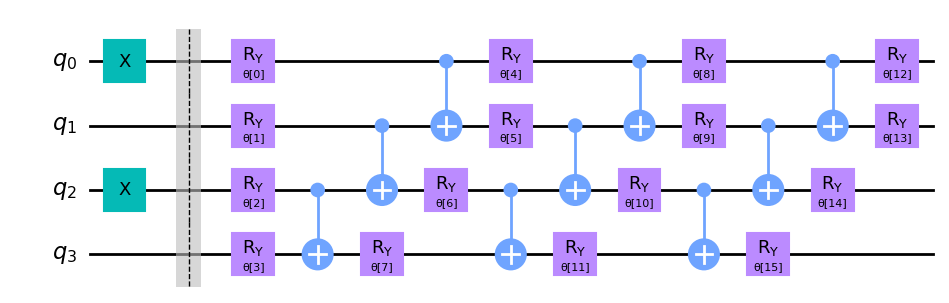

In [8]:
# Hartree focks state
num_particles = problem.num_particles
num_spatial_orbitals = problem.num_spatial_orbitals

init_state = HartreeFock(num_spatial_orbitals=num_spatial_orbitals,
                         num_particles=num_particles,
                         qubit_mapper=mapper)

# ansatz
ansatz = EfficientSU2(qubit_op.num_qubits, su2_gates=['ry']).decompose()

# Add the initial state
init_state.barrier()
ansatz = init_state.compose(ansatz)
ansatz.draw('mpl')

In [9]:
intermediate_info = []

def callback(eval_count, parameters, value, std):
    intermediate_info.append(value)
    clear_output(wait=True)
    plt.plot(intermediate_info, color='purple', lw=2, label=f'Simulated VQE {np.round(value,4)}')
    plt.ylabel('Energy')
    plt.xlabel('Iterations')
    
    # Exact ground state energy value
    plt.axhline(y=exact_energy,color="tab:red",ls="--", lw=2,label="Target: "+str(np.round(exact_energy,4)))
    plt.legend()
    plt.grid()
    plt.show()

In [10]:
optimizer = L_BFGS_B(maxiter=20)

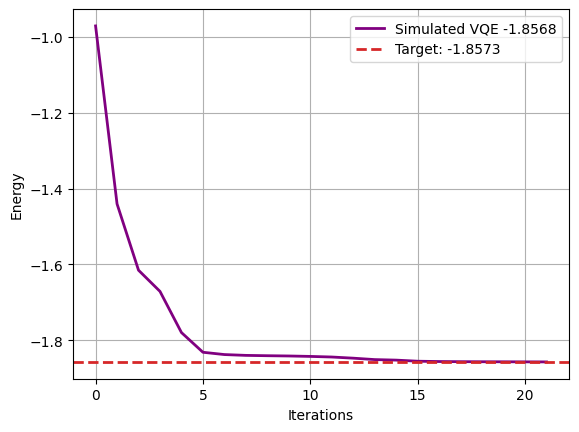

'Barrier' object has no attribute 'to_matrix'


In [11]:
qulacs_estimator = QulacsEstimator()
qulacs_gradient = QulacsEstimatorGradient(qulacs_estimator)

vqe = VQE(qulacs_estimator, 
          ansatz, 
          optimizer, 
          callback=callback, 
          gradient=qulacs_gradient
         )
result = vqe.compute_minimum_eigenvalue(operator=qubit_op)

In [12]:
print(result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 22,
    'eigenvalue': -1.856792226770143,
    'optimal_circuit': <qiskit_nature.second_q.circuit.library.initial_states.hartree_fock.HartreeFock object at 0x7f4423d17910>,
    'optimal_parameters': {   ParameterVectorElement(θ[1]): -1.311030993302368,
                              ParameterVectorElement(θ[2]): 5.325935798233073,
                              ParameterVectorElement(θ[3]): 1.2095948974450152,
                              ParameterVectorElement(θ[4]): -5.154494260584239,
                              ParameterVectorElement(θ[5]): 5.666947151364108,
                              ParameterVectorElement(θ[6]): 2.5743444878871973,
                              ParameterVectorElement(θ[7]): 2.44211123543697,
                              ParameterVectorElement(θ[8]): -5.410130960542249,
                              ParameterVectorElement(θ[9]): -1.2611676138000247,
                              ParameterVectorEl

In [13]:
def rel_err(target, measured):
    return abs((target - measured) / target)

In [14]:
# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(exact_energy, result.eigenvalue)

print(f'Expected ground state energy: {exact_energy:.12f}')
print(f'Computed ground state energy: {result.eigenvalue:.12f}')
print(f'Relative error: {rel_error:.12f}')

Expected ground state energy: -1.857275030202
Computed ground state energy: -1.856792226770
Relative error: 0.000259952578
